In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time
import os

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM4.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

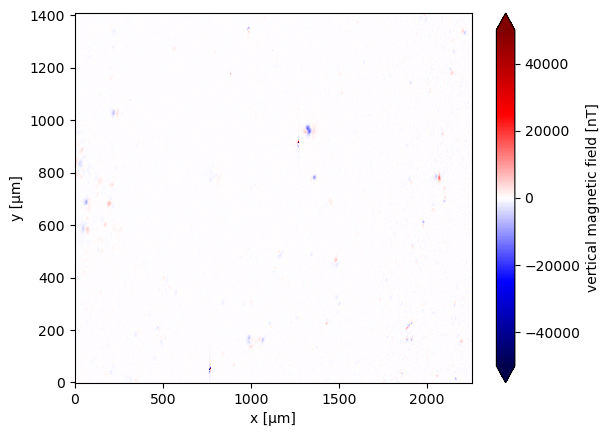

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 35.17 21.4 8.557 9.319 ... 50.4 60.44 49.07

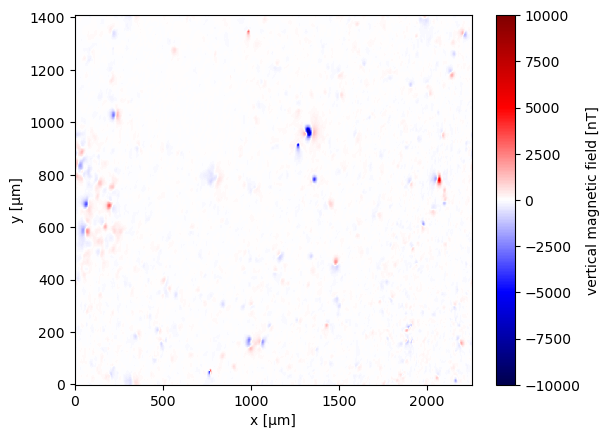

In [6]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 35.17 21.4 8.557 9.319 ... 50.4 60.44 49.07
    tga      (y, x) float64 5MB 7.034 6.126 4.062 6.029 ... 11.23 13.37 7.375
    x_deriv  (y, x) float64 5MB -5.858 -5.662 -2.571 ... 7.776 -0.2839 -4.839
    y_deriv  (y, x) float64 5MB -0.1312 1.164 0.9491 ... 0.927 0.776 0.06478
    z_deriv  (y, x) float64 5MB -3.891 -2.029 2.998 ... -8.054 -13.35 -5.565

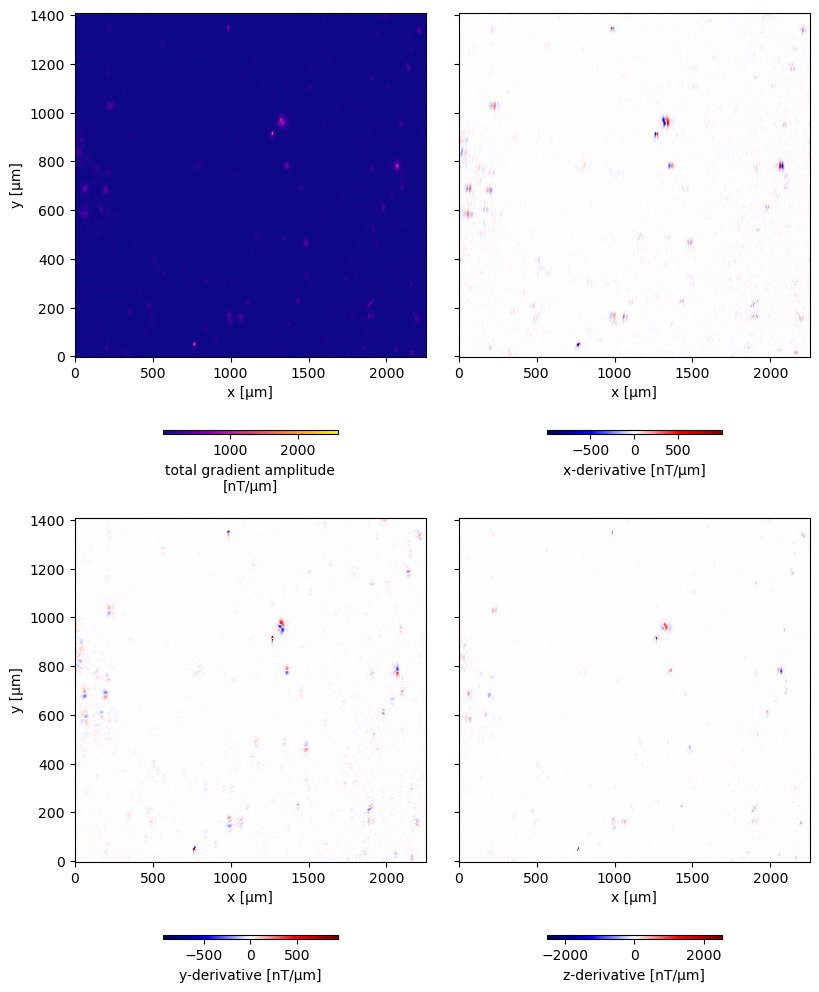

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

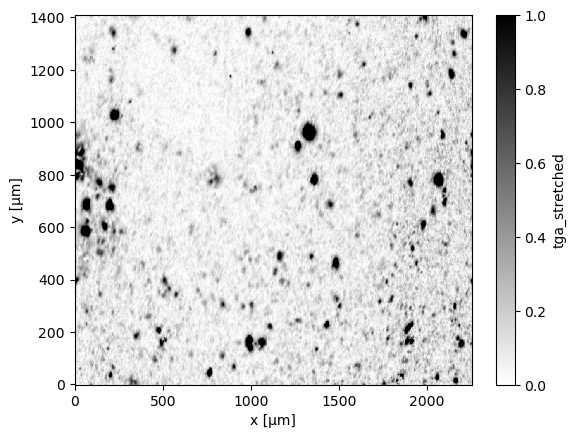

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 100],
    size_increment=1.0,
    threshold=0.05,
    overlap=1.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

726 potential sources detected within 1.7997 seconds


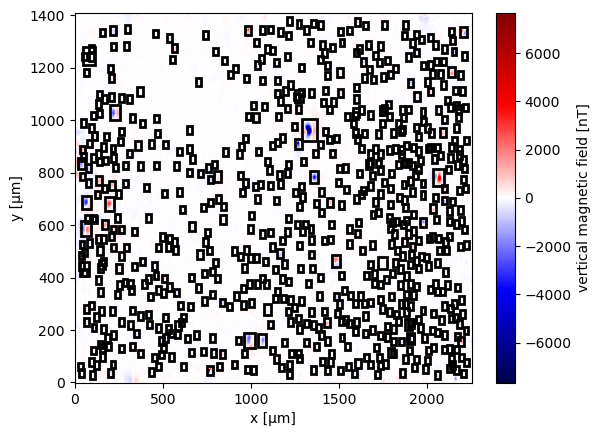

In [13]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

726 euler positions and dipole moments estimated within 3.6986 seconds


# Iterative Euler deconvolution

In [16]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 165.3182 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z          bz    z_deriv
0  749.65  30.55  10.0 -115.618022 -10.027975
1  752.00  30.55  10.0 -183.634247  -8.669418
2  754.35  30.55  10.0 -268.659719  -6.507989
3  756.70  30.55  10.0 -374.627864   7.033475
4  759.05  30.55  10.0 -488.370597  25.916755

In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [22]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

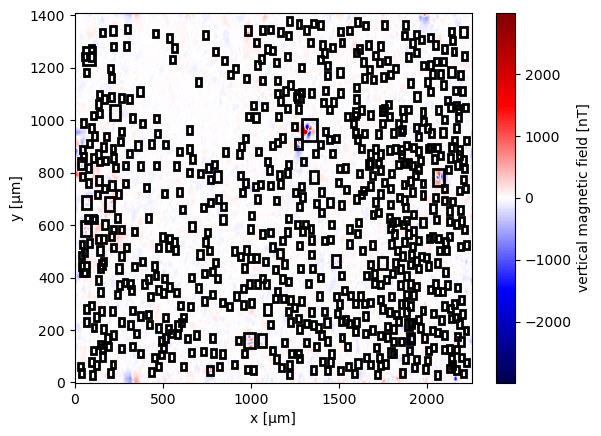

In [23]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

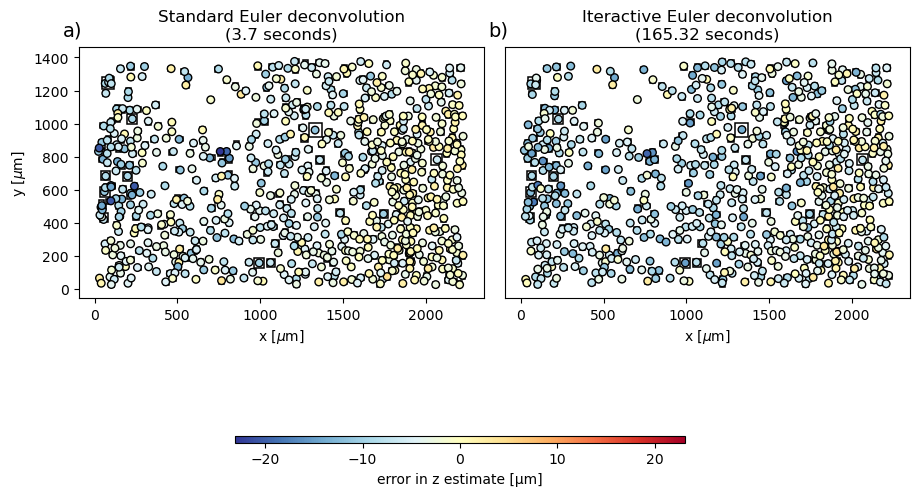

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

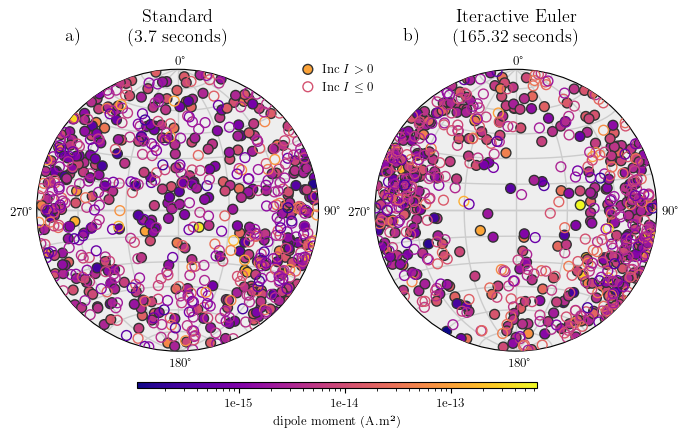

In [26]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

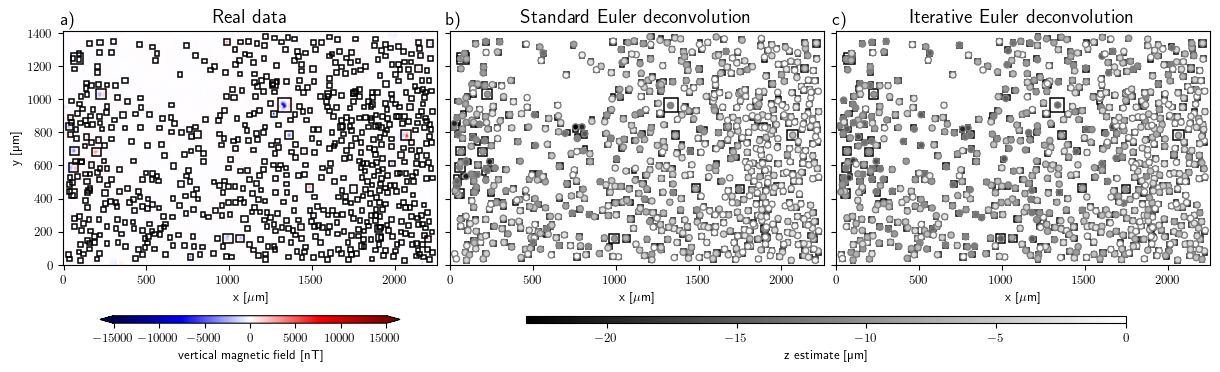

In [27]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


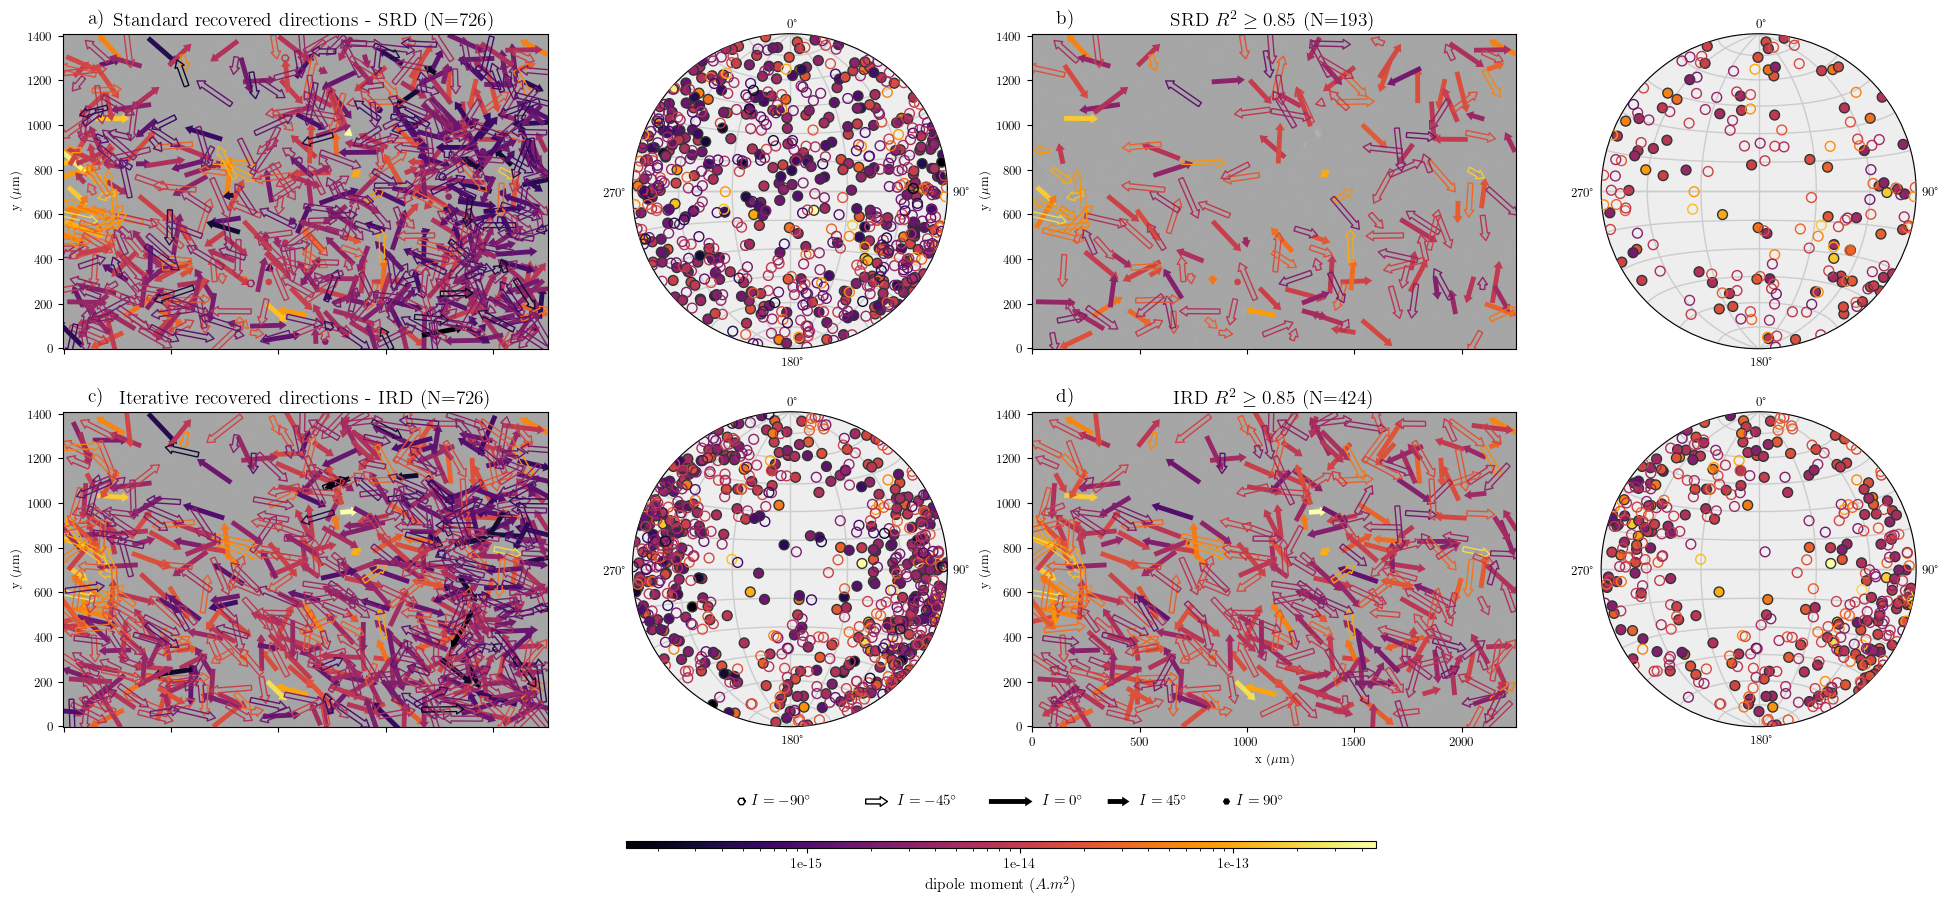

In [28]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

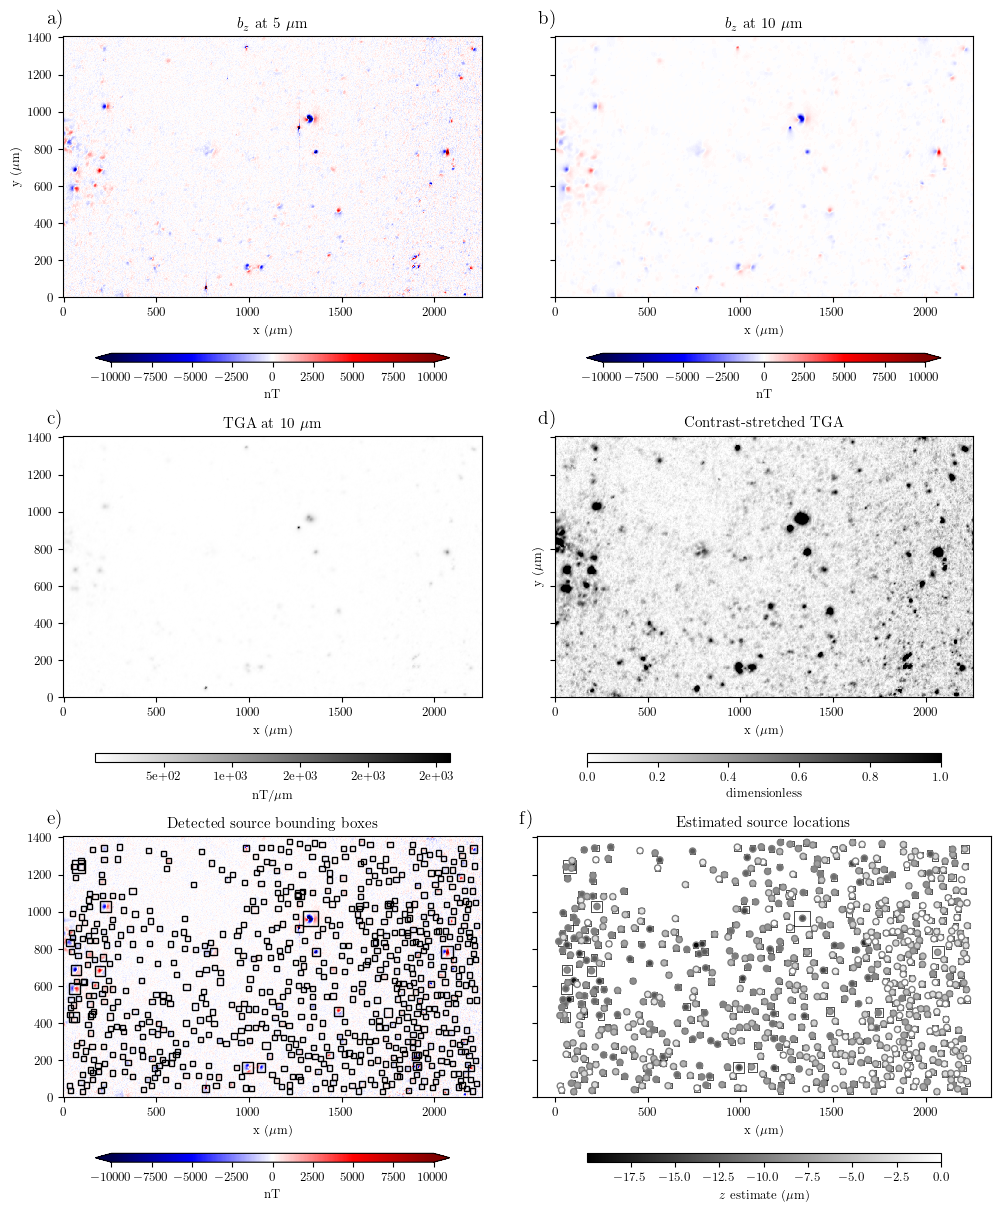

In [29]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [30]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [31]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 34.33 20.67 7.9 8.698 ... 22.2 49.0 59.29 48.15
    tga      (y, x) float64 5MB 7.06 6.115 3.967 5.965 ... 13.95 11.4 13.48 7.39
    x_deriv  (y, x) float64 5MB -5.81 -5.623 -2.548 ... 7.892 -0.1808 -4.742
    y_deriv  (y, x) float64 5MB -0.1797 1.107 0.886 ... 0.8923 0.7416 0.02483
    z_deriv  (y, x) float64 5MB -4.007 -2.132 2.908 ... -8.176 -13.46 -5.668

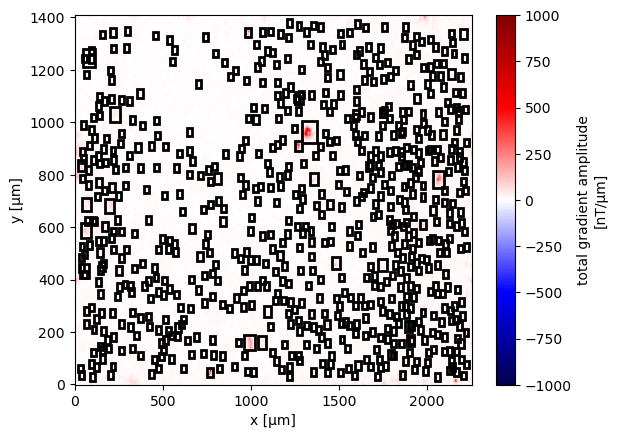

In [32]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [33]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [34]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.1,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [35]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

488 potential sources detected within 1.3023 seconds


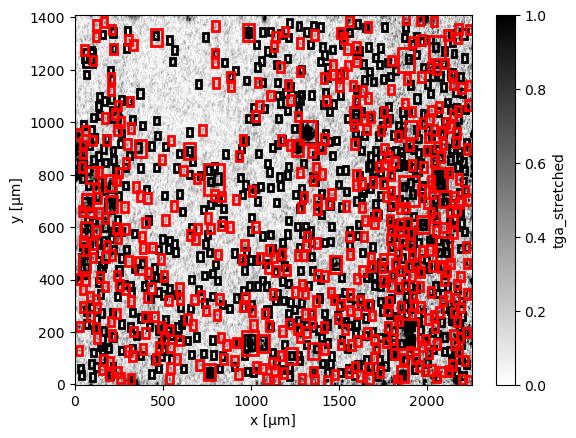

In [36]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [37]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[2209.41522369 2246.18477631  442.21522369  478.98477631]
[2209.41522369 2246.18477631  327.06522369  363.83477631]
[1542.01522369 1578.78477631 1368.11522369 1404.88477631]
[301.21522369 337.98477631   2.76522369  39.53477631]
[  2.76522369  39.53477631 935.71522369 972.48477631]
[1943.86522369 1980.63477631 1372.81522369 1409.58477631]
[1271.76522369 1308.53477631    2.76522369   39.53477631]
[  7.46522369  44.23477631 202.51522369 239.28477631]
[2021.41522369 2058.18477631 1365.76522369 1402.53477631]
[1069.66522369 1106.43477631    2.76522369   39.53477631]
[ 85.01522369 121.78477631 465.71522369 502.48477631]
[240.11522369 276.88477631   5.11522369  41.88477631]
[1654.81522369 1691.58477631    2.76522369   39.53477631]
[103.81522369 140.58477631 566.76522369 603.53477631]
[1440.96522369 1477.73477631  707.76522369  744.53477631]
[1448.01522369 1484.78477631 1201.26522369 1238.03477631]
[1624.26522369 1661.03477631  545.61522369  582.38477631]
[1123.7152236

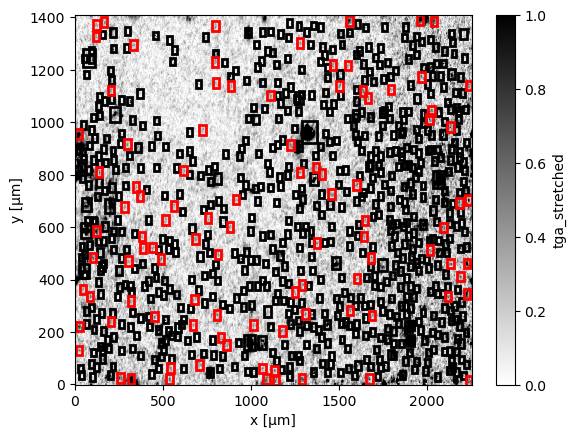

In [38]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [39]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 2.23030477e+03  4.60577359e+02 -1.57872034e+00]

[ 2.80463378e-15  4.62281839e-16 -1.70139672e-15]

(30.90310712087324, 80.64021557178958, 3.312767114798037e-15)

0.8687842571628553

piorou

[2.23220542e+03 3.45693866e+02 7.33951259e-02]

[ 1.17467885e-15 -1.74700161e-16 -9.84551291e-16]

(39.65964683387001, 98.45911908752919, 1.5426379358092036e-15)

0.4181571391542752

[1562.28344978 1385.2483572    -6.8114645 ]

[ 6.07689052e-15 -6.34536817e-15 -2.79883624e-15]

(17.669770348125393, 136.23811961505905, 9.220942462599369e-15)

0.9230781951702732

[325.80449401  14.58709817 -16.05448178]

[ 9.66614916e-14  1.88063636e-14 -1.10206625e-14]

(6.385655497461954, 78.99013460561973, 9.90887393666832e-14)

0.9835472785579175

[ 11.94305458 937.45051547 -14.05205104]

[ 2.29753274e-15 -8.96934854e-14  1.04179467e-14]

(-6.623095309640815, 178.5326676924065, 9.032570840067834e-14)

0.8150340262211738

[1972.43379409 1396.44961308   -7.05828066]

[ 9.70013163e-15  1.42205983e-14 -7.84432841e-15]

(24.498642091498468, 34.29861748300595, 1.891696214402614e-14)

0.8323836516448686

[1290.65108107   18.33921844   -8.53710496]

[ 1.04957923e-14 -4.26669273e-15 -5.51955350e-16]

(2.7890596968491166, 112.12245971414043, 1.1343322999367484e-14)

0.9464422605583503

[ 29.03172807 218.89532938  -8.59190383]

[ 8.88319044e-15  6.34357266e-15 -9.87653331e-16]

(5.1700597428361394, 54.46899975530813, 1.096026667797397e-14)

0.9277229504418149

[2038.01016755 1384.92256291   -4.60663371]

[ 1.57039748e-15 -1.43596099e-15  3.64233214e-15]

(-59.70546730231121, 132.4395881059471, 4.218378316583387e-15)

0.8364204790515417

[ 1.08720412e+03  2.01745329e+01 -8.55495300e-01]

[-1.83598355e-15 -2.45271063e-18  2.50904096e-16]

(-7.781785516319055, -90.0765420169027, 1.8530500490999937e-15)

0.770519199411215

[105.9696106  485.67274488  -3.70885557]

[ 2.09181477e-15 -1.82029140e-16 -1.58825837e-15]

(37.104385949392146, 94.97333463728802, 2.6327529885646284e-15)

0.7579835667492895

[267.04129657  22.56864203  -9.4113806 ]

[-9.60309188e-15 -1.14957070e-15  4.56303516e-15]

(-25.25769090143292, -96.82630218204851, 1.0694025264751564e-14)

0.8250349690513753

[1668.74827788   16.53205684   -2.28300877]

[-2.02612486e-15  7.38292954e-16  2.91347497e-16]

(-7.69437927748289, -69.97893230978788, 2.1760380944128032e-15)

0.7008851947618371

[121.21342317 594.27859438 -13.91424006]

[ 2.22730000e-14 -1.58371509e-14  9.47124335e-15]

(-19.114139046179858, 125.41461729068415, 2.892414783208426e-14)

0.7919029412192393

piorou

[1458.04643522  724.5337092    -1.46289127]

[-1.05180381e-15  9.22682908e-16  3.98181774e-16]

(-15.885679988793996, -48.74151097537829, 1.454710872865843e-15)

0.5513896735026278

[1471.86245242 1214.78428495   -4.93357154]

[ 2.70648632e-15 -6.93831857e-16 -8.57334083e-16]

(17.05850560191887, 104.3786335755258, 2.922583204996418e-15)

0.6509403136529588

[1643.74941603  563.33513955   -4.94007082]

[ 1.65070538e-15 -1.88428461e-15  1.20997808e-15]

(-25.781119292450857, 138.78040047192846, 2.781978379404035e-15)

0.7605496711564872

[1136.12691065   16.8927799    -2.93081072]

[ 2.00048734e-15 -4.01687563e-16  1.11699903e-16]

(-3.1334528628230953, 101.35371595837131, 2.0434723775597038e-15)

0.6481330566559942

[5.43615460e+02 6.29223121e+01 1.63156490e-02]

[ 8.00250033e-16 -4.40772456e-16  5.89793390e-18]

(-0.3698761882970653, 118.8456840258492, 9.136275275473836e-16)

0.6857382630422708

[ 166.14480394 1384.62465918  -12.0652597 ]

[ 1.03388853e-14  1.58627200e-15 -4.15525136e-15]

(21.66577849744564, 81.27725721672303, 1.1254995446607372e-14)

0.924366263704386

piorou

[ 2.23916254e+03  2.22100088e+01 -8.76845173e-01]

[ 1.56076717e-15 -2.13044600e-16  5.89908863e-18]

(-0.21456490888625385, 97.77283204091188, 1.5752513925049012e-15)

0.5073465144799584

[1127.95434777   53.83400435   -2.76275165]

[-1.10981908e-15  3.77069553e-16 -6.26768483e-16]

(28.134655040001853, -71.23441315101444, 1.3291796640583167e-15)

0.6055482147874529

piorou

[1.59844357e+03 7.58654010e+02 2.86178863e-01]

[-6.81094854e-16  5.30266764e-17 -3.18263629e-16]

(24.979521585456023, -85.54821421869376, 7.536536114449645e-16)

0.44901719631134285

[ 792.05875299 1231.30219852  -10.55290741]

[6.69553105e-15 6.81128052e-15 2.66468638e-15]

(-15.58869624490975, 44.50900375173505, 9.915857596617153e-15)

0.9559217439967067

piorou

[ 2.12621880e+03  3.35077592e+02 -5.74221303e-01]

[-1.00116979e-15 -3.15161223e-16  6.33758407e-16]

(-31.12389147747146, -107.4736361016131, 1.2260983903503014e-15)

0.4828019214486742

piorou

[2025.33320907 1033.0231551     2.06491926]

[-3.70693230e-17 -2.22025368e-16  2.28460806e-16]

(-45.42471661442281, -170.52133418051935, 3.2072377278578234e-16)

0.17363999590149848

[861.68512586 148.55053479  -8.59816836]

[ 4.43580848e-15  2.78134176e-15 -1.29451031e-15]

(13.887754474773113, 57.9114549582211, 5.393330671574598e-15)

0.8137543340457922

[479.85961465 475.19979086 -11.18368053]

[ 6.03856210e-15  3.32271009e-15 -2.58035196e-15]

(20.52482215518458, 61.17827353475441, 7.359541481492975e-15)

0.6877141889757696

[318.67720973 320.67068017  -6.16884029]

[ 8.45869789e-16  2.43052932e-15 -1.84438411e-15]

(35.628395975032255, 19.188855155928366, 3.1661840107360555e-15)

0.7137771415553559

[877.08318814 606.3597384   -6.81725003]

[ 2.68179531e-15 -2.75226783e-15  1.00595962e-15]

(-14.669635035217732, 135.74300793055565, 3.97227378687691e-15)

0.8405941835453448

[ 71.04342193 334.13405098  -8.72919874]

[ 9.41981928e-15 -1.75615125e-15 -1.32709897e-16]

(0.7934809095692361, 100.5605037505197, 9.583040982132881e-15)

0.7817755299827898

[1502.36212973 1141.54653564   -7.08302446]

[ 1.97619735e-15 -1.66738378e-15  2.29435478e-15]

(-41.58410787254537, 130.15544529834526, 3.4568176809358017e-15)

0.8451650608563884

[1310.50591865  277.59184873  -10.28662091]

[ 6.85645932e-15 -2.64104396e-15  1.76940149e-15]

(-13.539928557030962, 111.06621788338506, 7.557574298008373e-15)

0.7509040149864878

piorou

[1.97078769e+03 1.16753928e+03 1.77204021e-01]

[-1.23388593e-16  9.22396772e-16 -6.41405560e-17]

(3.942756573535795, -7.619198272258144, 9.328207550234084e-16)

0.45032872570172056

[371.17785606 719.72468571 -10.44691826]

[-4.43432426e-15 -1.31919399e-15  4.07316320e-15]

(-41.36130149087679, -106.5675341178795, 6.163940530339927e-15)

0.8887112876496052

[691.58625826 561.46062778  -3.77296154]

[-2.44360813e-15 -1.23339960e-15  6.67756754e-16]

(-13.709661459446293, -116.7821442888598, 2.8175156342576954e-15)

0.7254366946277451

[1276.14580525  815.05725256   -8.49048678]

[-2.30115604e-15  4.69453538e-15 -2.23635488e-15]

(23.158781801258268, -26.1130585121178, 5.6864105301256765e-15)

0.8202487077960257

[ 21.66716117 132.9484073  -11.15246433]

[ 9.08511646e-15 -1.91873985e-15 -8.23210308e-16]

(5.066326651430658, 101.92539224098603, 9.321940724627743e-15)

0.925400432378409

piorou

[1567.1219578   284.46160363   -1.72403863]

[-7.80915793e-16  2.47162533e-16 -6.32286964e-16]

(37.66571235705362, -72.43724159772043, 1.0347490511314834e-15)

0.38374977137891

[913.76685348 708.32051301  -8.23784877]

[ 1.47586735e-15 -3.58823793e-15  1.86544351e-15]

(-25.678089984501824, 157.64229177892543, 4.305056954028808e-15)

0.8371389111907479

[1374.31773931  535.8026661    -7.03073545]

[3.62608596e-15 6.69312452e-16 2.33349198e-15]

(-32.32721562606968, 79.54190623432012, 4.3636754423729575e-15)

0.840391445168661

[207.3150574  241.03981467  -4.2528255 ]

[-1.98973432e-15  2.19919688e-16  7.96856739e-16]

(-21.70552166063568, -83.69286014575323, 2.1546201521067275e-15)

0.711554196434239

piorou

[345.59537892 741.62151071  -1.88880641]

[ 3.95558863e-16 -1.23063303e-15 -3.03950577e-17]

(1.346998689691868, 162.18118511336652, 1.2929997417470661e-15)

0.35468180740977306

[387.79555865 559.79675653  -9.87034429]

[-6.33098785e-15  2.81232756e-15  1.77311493e-15]

(-14.356764940465629, -66.04843082572057, 7.150841204557544e-15)

0.9282770923733497

[827.30529474 178.25172606  -4.89681406]

[ 2.41250909e-15 -1.45365913e-15  4.86329799e-16]

(-9.796360708615435, 121.07109618766131, 2.8582934848815674e-15)

0.8918769077048032

[542.67559156  18.05154443 -10.79711281]

[ 4.58081857e-15 -7.06581731e-15 -3.78871946e-15]

(24.2241510043576, 147.04437770223353, 9.233854461803734e-15)

0.7398097523395142

[ 327.58456903 1299.24455928   -3.40246259]

[ 6.21926322e-16 -1.69878617e-15  4.61350172e-16]

(-14.306803108445942, 159.89230070922204, 1.8669522731368404e-15)

0.7562607272611783

[ 117.65020547 1325.43205479  -11.30543872]

[-7.15699435e-15  7.21759446e-15  9.47212317e-16]

(-5.32394092047887, -44.7584550033914, 1.0208498862334183e-14)

0.9320427134454471

[ 207.25634252 1121.67001845   -5.77481573]

[ 3.20701194e-15  4.26181972e-16 -6.01810043e-16]

(10.53766516577068, 82.43027768383844, 3.290703872672945e-15)

0.8137484388758929

[2.09512595e+03 5.99718833e+02 1.51327676e+00]

[ 4.27314033e-16 -2.93703958e-16 -1.54972169e-16]

(16.640148030729073, 124.50174481344787, 5.411798880190898e-16)

0.43175016610748584

[309.55482618 473.41896346  -5.78391241]

[-3.31730977e-15  3.94696904e-16 -4.02569035e-16]

(6.871244965660011, -83.21478790363395, 3.3648761606151536e-15)

0.8437861188142268

[809.47604328 499.96693283  -3.5335106 ]

[-1.71619398e-15  9.65682694e-16 -2.20807970e-16]

(6.39780153398493, -60.63404082037513, 1.9815703392289625e-15)

0.7149390125189345

piorou

[2.24063057e+03 1.14229282e+03 1.75535961e+00]

[2.46380560e-16 2.81739719e-16 1.75940797e-17]

(-2.691414062892028, 41.16960078136586, 3.746868041453312e-16)

0.10138336954196758

[138.29207344 807.95341061 -12.05821148]

[-1.19920061e-14  2.95811608e-15  6.14692705e-15]

(-26.458055629836434, -76.1432526235348, 1.3796498609099953e-14)

0.8892567880622585

[1.78910616e+03 1.12530398e+03 7.56048328e-01]

[-5.18410378e-16  1.23562755e-16  5.08385133e-17]

(-5.449178766251839, -76.59372680067378, 5.353518738348066e-16)

0.6257647641795627

[722.27460374 970.64747064   1.25360052]

[ 4.11191106e-16 -2.19732137e-17  3.75958955e-17]

(-5.216722473569476, 93.05886011630672, 4.1349050638874584e-16)

0.5281968546406929

[558.23686427 684.5058292   -2.93607014]

[ 1.15044920e-15 -2.39335806e-17  7.62156478e-16]

(-33.518208435726855, 91.19179133242143, 1.3802132697207115e-15)

0.7550684453588405

[679.73083502 320.59336016  -7.43318831]

[ 5.98601338e-16 -1.70629224e-15 -2.43627052e-15]

(53.41648413596972, 160.66811241310646, 3.034002444511995e-15)

0.759128674810884

[ 804.20431273 1367.90373486   -6.27780382]

[ 4.79627327e-16  2.80157927e-15 -8.99520597e-16]

(17.561121358306167, 9.714795281230309, 2.981279273143118e-15)

0.7403440321414588

[ 877.10229596 1141.53574247   -8.4329749 ]

[ 4.19827741e-15 -3.43279804e-15  1.66723834e-15]

(-17.089244059811687, 129.271775501037, 5.67356318950844e-15)

0.7738647433233513

piorou

[4.44595928e+02 2.51940308e+02 4.22122929e-01]

[ 3.22256630e-16 -9.45823485e-17 -3.93672034e-16]

(49.5318070922579, 106.35696841787545, 5.174677058506738e-16)

0.27552638827108833

[1364.51488961  823.46829547   -5.63910852]

[ 1.45109449e-15 -3.52218455e-15  4.99267742e-16]

(-7.466760786840724, 157.60897236985355, 3.841969224340528e-15)

0.8229320861904398

[2025.74952662 1007.62802234   -4.25154862]

[-9.36319087e-16  2.21317619e-15  4.94435410e-16]

(-11.626350038059003, -22.931558411965188, 2.4534279358543467e-15)

0.5747853133229635

piorou

[ 1.25455045e+03  3.56418099e+02 -6.50523112e-01]

[ 9.06932092e-16 -3.54473161e-16 -4.70301563e-16]

(25.779745569102918, 111.34797492971893, 1.081369780466923e-15)

0.46723562812794095

piorou

[ 2.13307555e+03  9.84402953e+02 -1.55956879e+00]

[-5.98619778e-16  1.61100006e-16 -7.46834177e-16]

(50.30523485267666, -74.93747867020477, 9.705978257349577e-16)

0.20225106187651343

[667.85386752 225.3289786   -7.90622684]

[ 1.82210088e-16 -2.65621828e-15  1.96255121e-15]

(-36.39464621945947, 176.07579700134335, 3.3076129281095102e-15)

0.7548683887029598

[1605.2792116   408.76763593   -3.49253239]

[-1.82209302e-15 -4.32832702e-16  5.78468895e-16]

(-17.16485806598673, -103.36276670101816, 1.960100346821032e-15)

0.7828486084301378

piorou

[1646.06092978  619.93687825   -2.05900275]

[-1.24060965e-15 -9.10494430e-16 -3.88217671e-17]

(1.4451225165327521, -126.27527566266338, 1.539356863057089e-15)

0.3872425298499388

[1286.63461369 1302.00468128   -3.13492397]

[-1.58181734e-15  6.10898927e-16  5.09653403e-16]

(-16.728635027679026, -68.88340543146678, 1.7706185874753402e-15)

0.7830883336382399

[515.39643818 620.36256196  -5.31041117]

[-1.55351809e-15  1.57564250e-15  1.46294242e-15]

(-33.47089804934272, -44.59490279763924, 2.6525965163356255e-15)

0.6866700343705675

[1680.08578554  486.65350335   -8.07456487]

[-9.00607162e-16 -4.58567921e-15  2.15823469e-15]

(-24.78864415756285, -168.8887791113544, 5.147574576883534e-15)

0.7483463329008826

[277.53143579 673.05326559  -9.75783748]

[-6.33891560e-15 -4.89390471e-16 -1.29562274e-15]

(11.518327160094938, -94.41471350711372, 6.488450684889694e-15)

0.8631168649370939

[1110.39095167 1106.21994062   -5.55393948]

[-9.11398698e-16  3.51607152e-15 -8.02919287e-16]

(12.464869676460513, -14.531776834314163, 3.719957786397865e-15)

0.8057042692348279

piorou

[ 1.18013905e+03  2.07808638e+02 -4.06369589e-01]

[ 5.34267614e-16 -4.98650069e-17 -3.90259063e-16]

(36.028216955132706, 95.33216203572123, 6.634987099280273e-16)

0.25875294807858784

[615.3226201  816.86094848  -7.08015056]

[ 4.18860162e-15 -2.49425629e-15  4.20641227e-17]

(-0.4943657833383714, 120.77323329262552, 4.875188953218382e-15)

0.9038058392259064

[1682.82161083  262.30973301   -7.22426591]

[5.10776260e-15 8.46146571e-16 1.33737331e-15]

(-14.483540470168414, 80.5938645794017, 5.347314292019385e-15)

0.812341379694076

[450.69021151 527.73081378 -12.81443796]

[-1.19388886e-14 -2.56075178e-15  2.33942892e-15]

(-10.846018455057262, -102.10585371339835, 1.2432515367986687e-14)

0.8586494591163212

[805.30151469 270.86521003  -2.99309874]

[ 1.43605772e-15 -1.33153258e-15  5.38260340e-16]

(-15.368271690226065, 132.83710613506202, 2.03100097920783e-15)

0.4495418287909432

piorou

[1223.52663392  920.17668428   -6.87644696]

[ 3.09299613e-15 -5.66436620e-15  1.70642833e-15]

(-14.810439490197542, 151.36349471434815, 6.675594894558146e-15)

0.5983884951229397

[2193.48646723  691.84180941   -3.13305533]

[-2.35868004e-15 -3.22216210e-16  5.41480807e-16]

(-12.8142962904887, -97.77895025597871, 2.441392282179101e-15)

0.623659024084391

[1639.93052488 1121.6333809    -2.39412825]

[-7.28280397e-16  1.34002340e-15 -8.10656396e-16]

(27.991931976166576, -28.523343329984268, 1.7271997126478333e-15)

0.6685402155220852

[1404.24161003  797.67572435   -7.47201301]

[-6.55024760e-16 -5.38990432e-15  1.08484763e-15]

(-11.29913138498226, -173.07093219815744, 5.53687822139501e-15)

0.7881420579963042

piorou

[ 2.19558654e+03  4.06353531e+02 -1.12854280e-01]

[-3.84241498e-16  2.06829356e-16  4.54186335e-16]

(-46.1460125363952, -61.70732648190326, 6.29845328789254e-16)

0.3143962830665077

[ 44.70298026 363.79016769  -8.42649092]

[-2.33998223e-15  2.45587865e-15 -3.24884168e-15]

(43.76356802696248, -43.61566379627626, 4.697002129304328e-15)

0.8169558891651097

[ 803.60178108 1148.37284436   -9.14232738]

[ 5.39344674e-15 -2.91702540e-15 -8.59420602e-16]

(7.978556661936448, 118.40657258166833, 6.191680599559259e-15)

0.9644868160239348

[2017.31033892  509.27116794   -6.41202307]

[ 9.05821022e-16 -3.16990135e-16  3.22398550e-15]

(-73.4232973718122, 109.28738516262358, 3.363789083205947e-15)

0.6495511600196259

piorou

[7.07149205e+02 5.84311791e+01 6.05268124e-01]

[-9.26362635e-18 -2.50624686e-16 -1.14184308e-16]

(24.479200172973677, -177.88318865147727, 2.755659707215636e-16)

-0.08389652387455637

[759.06292951 633.32389223  -8.81049342]

[-1.13470031e-15 -5.31800323e-15 -2.39026335e-16]

(2.516939412167551, -167.95543648066615, 5.4429621255150015e-15)

0.8229104671095491

[1556.30317129 1217.878046    -12.37229648]

[ 7.14485641e-15  5.55184279e-15 -1.43756859e-15]

(9.027529421818306, 52.15134639318371, 9.161797585652198e-15)

0.9059287623957233

piorou

[2132.52242343  457.16785303    3.4423067 ]

[-1.50203164e-16 -7.60534104e-18  6.67961949e-17]

(-23.947762117506933, -92.89862151336943, 1.645617315459001e-16)

0.16019478429403966

piorou

[ 2.24429508e+03  7.07174862e+02 -1.55015219e+00]

[-2.04081545e-15 -5.38126157e-16  7.47919089e-16]

(-19.512709169001962, -104.77163963298666, 2.239171814002942e-15)

0.21165110071165072

[1062.01706708   59.45768539   -8.10053756]

[-1.18570280e-15 -2.65334529e-15 -2.95411682e-15]

(45.46824083975045, -155.9215220859865, 4.144024435642242e-15)

0.8213634634224056

[1018.8936721   226.72527189   -8.85200874]

[ 4.96247834e-15  1.28796958e-16 -2.86302417e-15]

(29.973773902167153, 88.51326992320605, 5.73059222953312e-15)

0.8575214412051209

[ 123.53704407 1370.6536156    -8.35869349]

[-4.41239042e-15  2.55224492e-16  3.01412743e-17]

(-0.39073135394323233, -86.6895472194788, 4.4198684657877495e-15)

0.9144198345817325

[301.36375999 914.36421985  -3.9988937 ]

[-8.96095120e-16 -5.44757118e-16  1.26438072e-15]

(-50.32739906489186, -121.29639346133297, 1.6426823759099937e-15)

0.7867530220261139

[1290.28606238  379.98876121  -12.88959564]

[-1.31051557e-14  4.56083373e-15 -8.98327687e-16]

(3.7041126359076872, -70.81116919094475, 1.3905153795148107e-14)

0.9385547151966828

[384.84100624 516.29268899 -11.75813635]

[4.62214548e-15 7.29695693e-15 1.87189789e-15]

(-12.227637170818703, 32.35158714824278, 8.838201795559177e-15)

0.9159738990699422

piorou

[1.66905040e+03 1.10050992e+03 7.30243283e-01]

[-1.61605834e-16  4.39501276e-16 -2.01711942e-16]

(23.304391363498738, -20.18861460169107, 5.098681442600219e-16)

-0.009231245093541451

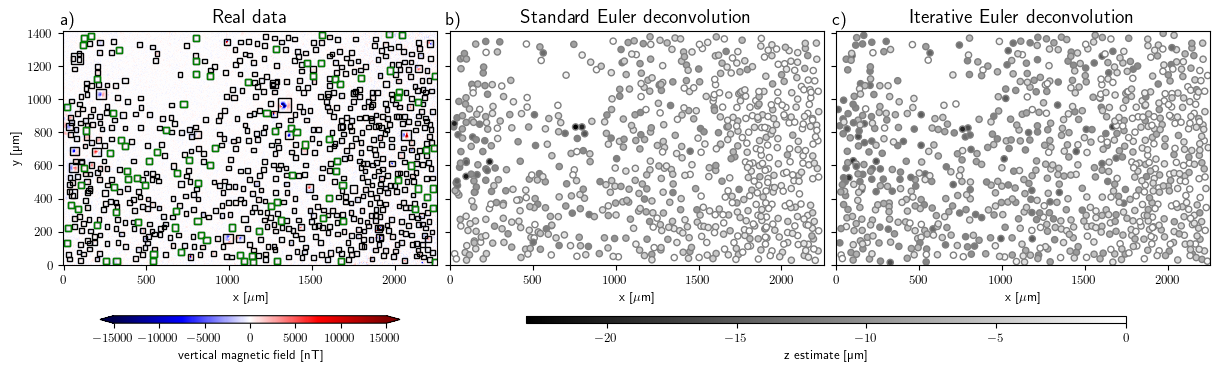

In [40]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:74: DeprecationWarning: invalid escape sequence '\m'
<>:102: DeprecationWarning: invalid escape sequence '\m'
<>:103: DeprecationWarning: invalid escape sequence '\m'
<>:183: DeprecationWarning: invalid escape sequence '\c'
<>:185: DeprecationWarning: invalid escape sequence '\c'
<>:187: DeprecationWarning: invalid escape sequence '\c'
<>:189: DeprecationWarning: invalid escape sequence '\c'
<>:191: DeprecationWarning: invalid escape sequence '\c'
<>:194: DeprecationWarning: invalid escape sequence '\g'
<>:195: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:74: DeprecationWarning: invalid escape sequence '\m'
<>:102: DeprecationWarning: invalid escape sequence '\m'
<>:103: DeprecationWarning: invalid escape sequence '\m'
<>:183: DeprecationWarning: invalid e

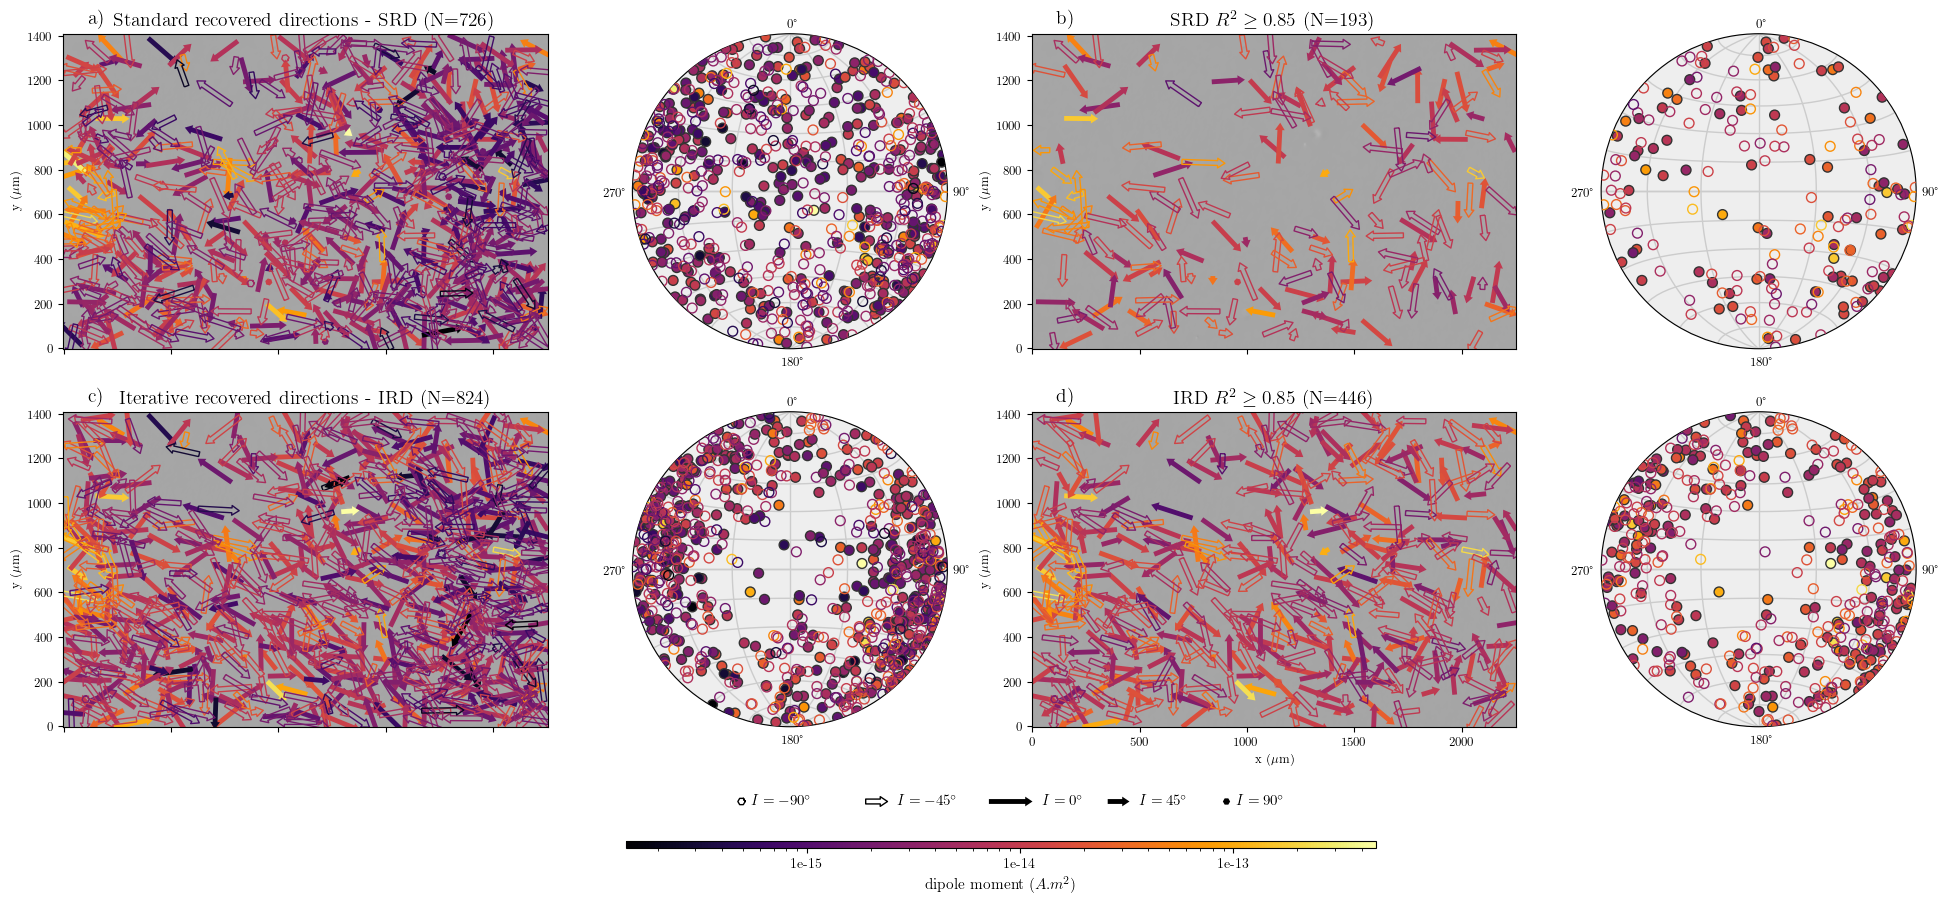

In [41]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    

    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

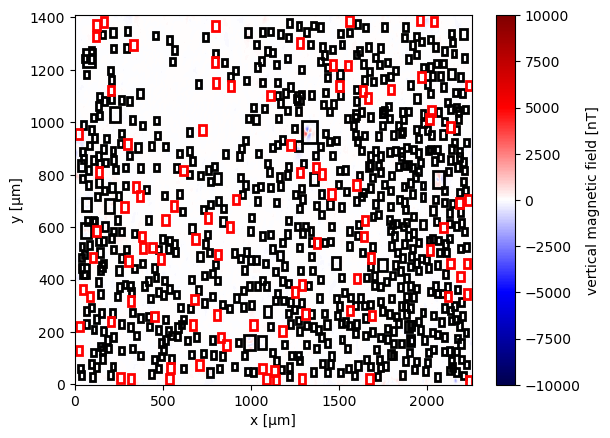

In [42]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [43]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([ 0.92730172,  0.94308567,  0.99413675,  0.86642667,  0.96958729,
        0.99484153,  0.95906299,  0.9865199 ,  0.97480446,  0.99907287,
        0.98103156,  0.91027282,  0.97061709,  0.87110079,  0.93691174,
        0.91921121,  0.93212371,  0.98212975,  0.96257858,  0.98644038,
        0.95072719,  0.98314412,  0.96223845,  0.9876409 ,  0.94869428,
        0.9898658 ,  0.96415881,  0.99607043,  0.98189572,  0.9890792 ,
        0.9915335 ,  0.99155894,  0.95501793,  0.98150356,  0.99419625,
        0.9809111 ,  0.98893984,  0.97904761,  0.85210418,  0.97670632,
        0.97824074,  0.57625849,  0.97482704,  0.27566504,  0.97155912,
        0.94137654,  0.75217086,  0.54594316, -0.01297305,  0.97377857,
        0.98942232,  0.96323322,  0.69692346,  0.99374926,  0.6848993 ,
        0.96507213,  0.95933705,  0.99038726,  0.94900048,  0.97712851,
        0.95533766,  0.86654016,  0.8862876 ,  0.97726403,  0.94662906,
        0.9553159 ,  0.97292953,  0.9306001 ,  0.84446538,  0.94

# Show the observed and predicted data

In [44]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

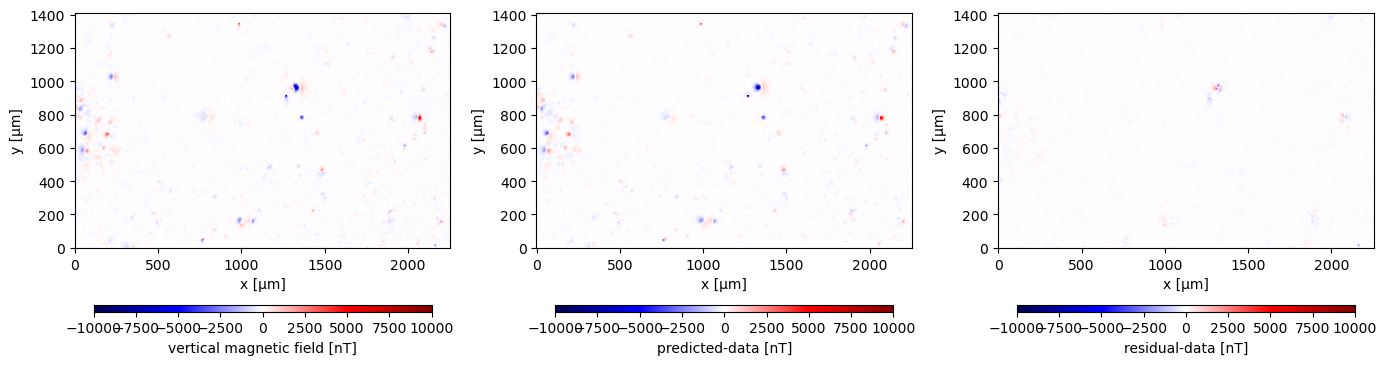

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.9273017225041493


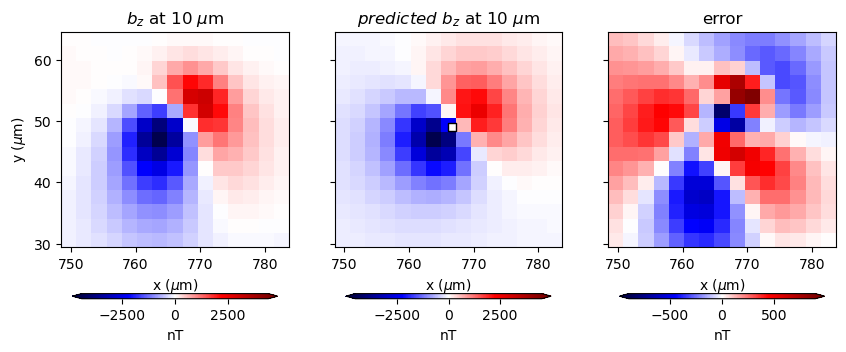

2
Individual source:   R2 = 0.9430856711713366


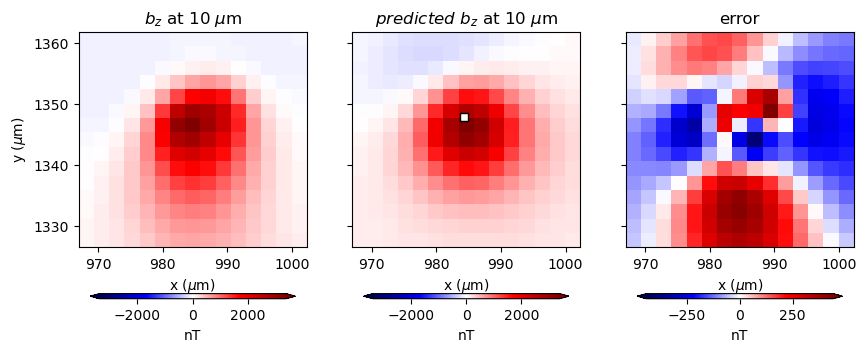

3
Individual source:   R2 = 0.9941367508948135


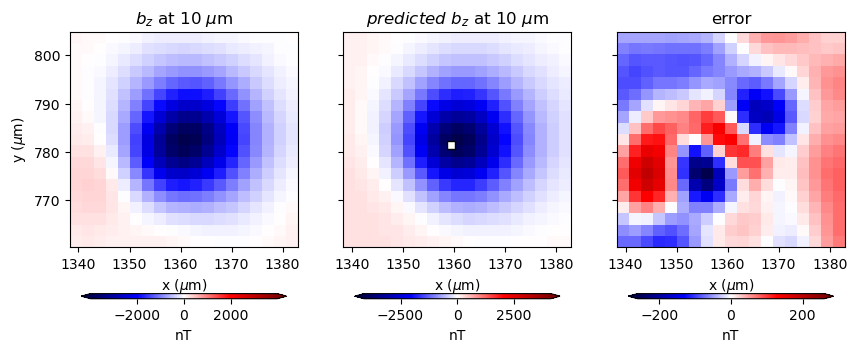

4
Individual source:   R2 = 0.8664266733172874


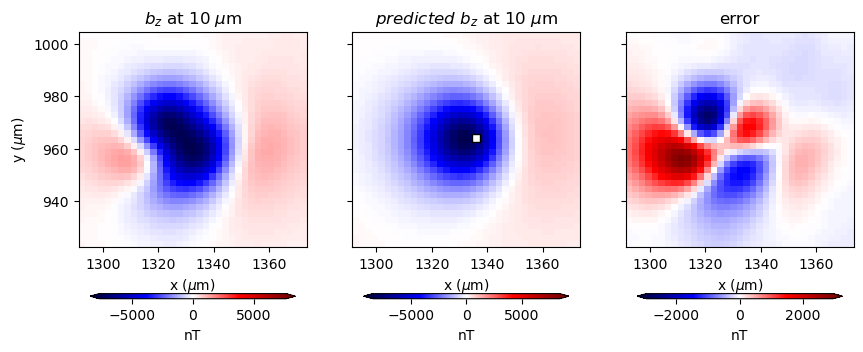

5
Individual source:   R2 = 0.9695872920060615


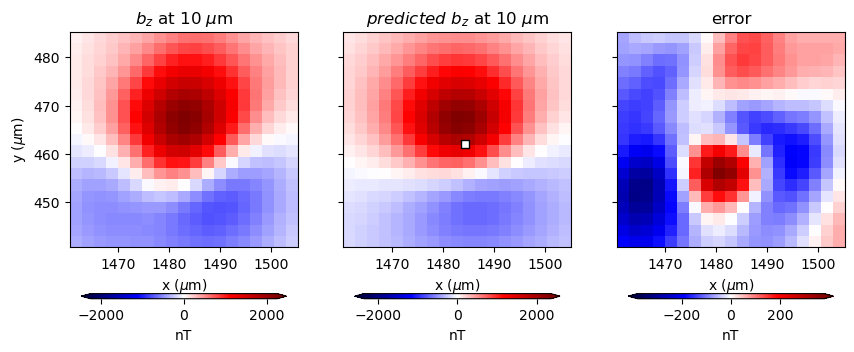

In [46]:
i = 0
slice_start=0#-20
slice_end=5#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [47]:
# Nome do arquivo ZIP
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [48]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)